<a href="https://colab.research.google.com/github/JuanCastrillonL/Data-Integration-Analytics/blob/main/parcial_2_Juan_Jose_Castrillon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Librerias

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import skew

Carga de datos y Organizacion

In [ ]:
file_path = '/content/sample_data/3. Perdida Productividad_Zonas(I) (3).xlsx'
xls = pd.ExcelFile(file_path)
df_observados = xls.parse('Datos Observados', skiprows=11)

# Elimino las dos primeras columnas porque estan vacias
df_observados = df_observados.drop(columns=df_observados.columns[:2])

# Renombrar columnas del xlsx
df_observados.columns = ['Mensual', 'Semestral', 'Diaria', 'WD', 'Perdida', ' ', 'Frecuencia', 'Severidad', 'LDA']

# Eliminar columna vacía, que le asigné ''
df_observados = df_observados.drop(columns=[' '])

# Filtrar datos para el análisis, solo necesito severidad y frecuencia
XDB = df_observados[['Frecuencia', 'Severidad']].copy()
XDB['Severidad'] = XDB['Severidad'] / 1000  # convertir a millones de USD
XDB = np.array(XDB)

Defino las funciones que voy a usar a lo largo del trabajo

In [ ]:
# Aplico K-Means para agrupar los datos en en los clusters que quiero, en esta caso 5
def clusterizar_datos(X, n_clusters):
    modelo = KMeans(n_clusters=n_clusters, init='random', random_state=42)
    modelo.fit(X.reshape(-1, 1))
    centros = np.sort(modelo.cluster_centers_.flatten())
    sigma = np.array([np.sum(np.abs(centros - c)) / 4 for c in centros]).reshape(-1, 1)
    return centros, sigma

def calcular_pertenencia(valor, centros, sigma):
    # Calculo la pertenencia de un valor a cada centro usando una función gaussiana.
    return np.exp(-0.5 * ((centros - valor) / sigma) ** 2)

# Devuelvo una matriz de impacto base, donde se representan niveles de impacto según combinaciones de frecuencia y severidad.
def crear_matriz_impacto():
    return np.array([[1, 1, 1, 2, 2],
                     [1, 2, 2, 3, 3],
                     [1, 2, 3, 3, 4],
                     [2, 3, 3, 4, 4],
                     [2, 3, 4, 4, 5]])

# Genero un mapa de calor de una matriz con etiquetas y título, útil para visualizar relaciones entre frecuencia y severidad.
def visualizar_matriz_calor(matriz, titulo, etiquetas_x, etiquetas_y):
    plt.figure()
    sns.heatmap(matriz, annot=True, cmap='RdYlGn_r', fmt='.2f')
    plt.title(titulo)
    plt.xlabel('Severidad (MUSD)' )
    plt.ylabel('Frecuencia (Mes)')
    plt.xticks(np.arange(len(etiquetas_x)) + 0.5, etiquetas_x, rotation=90)
    plt.yticks(np.arange(len(etiquetas_y)) + 0.5, etiquetas_y, rotation=0)
    plt.tight_layout()
    plt.show()

# Calculo la matriz borrosa a partir de las pertenencias de los valores de frecuencia y severidad frente a los centros generados por K-Means.
def generar_matriz_borrosa(x_frecuencia, x_severidad, centros_frecuencia, centros_severidad, sigma_frecuencia, sigma_severidad):
    pertenencia_frecuencia = calcular_pertenencia(x_frecuencia, centros_frecuencia.reshape(5,1), sigma_frecuencia)
    pertenencia_severidad = calcular_pertenencia(x_severidad, centros_severidad.reshape(5,1), sigma_severidad)
    matriz_borrosa = np.outer(pertenencia_frecuencia, pertenencia_severidad)
    return matriz_borrosa

# De la matriz borrosa selecciono los 4 valores más altos para formar una matriz umbral
def obtener_matriz_umbral(matriz_borrosa):
    valores_ordenados = np.sort(matriz_borrosa.flatten())[::-1]
    matriz_umbral = np.zeros(matriz_borrosa.shape)
    for i in range(4):
        matriz_umbral[np.where(matriz_borrosa == valores_ordenados[i])] = 1
    return matriz_umbral

# Simulo 1000 escenarios de riesgo
def simular_escenario_riesgo(centros_frecuencia, centros_severidad, sigma_frecuencia, sigma_severidad, datos_frecuencia, datos_severidad, matriz_probabilidad, factor_negocio, matriz_impacto_base):
    matriz_impacto = matriz_impacto_base.astype(float).copy()
    matriz_impacto[(matriz_impacto > 1) & (matriz_impacto < 5)] *= factor_negocio
    resultados_LDA, resultados_LDAm = np.zeros((1000, 1)), np.zeros((1000, 1))

    for iteracion in range(1000):
        muestra_frecuencia = datos_frecuencia.sample(n=1).values[0][0]
        muestra_severidad = datos_severidad.sample(n=1).values[0][0]

        matriz_borrosa = generar_matriz_borrosa(
            muestra_frecuencia, muestra_severidad,
            centros_frecuencia, centros_severidad,
            sigma_frecuencia, sigma_severidad
        )

        matriz_umbral = obtener_matriz_umbral(matriz_borrosa)

        resultados_LDA[iteracion] = muestra_frecuencia * muestra_severidad
        resultados_LDAm[iteracion] = np.sum(
            matriz_probabilidad * matriz_borrosa * matriz_umbral * matriz_impacto_base
        ) / np.sum(matriz_borrosa * matriz_umbral * matriz_impacto)

    return resultados_LDA.flatten(), resultados_LDAm.flatten(), matriz_impacto

# Calculo estadísticas descriptivas de la distribución de pérdidas
def calcular_metricas_riesgo(distribucion):
    descripcion = pd.Series(distribucion.flatten()).describe()
    valor_operacional = np.percentile(distribucion, 99.9)
    exposicion_neta = (descripcion['mean'] + valor_operacional) / 2
    asimetria = skew(distribucion.flatten())

    metricas = pd.DataFrame({
        'Muestras': [descripcion['count']],
        'Media': [descripcion['mean']],
        'Desviación': [descripcion['std']],
        'Mínimo': [descripcion['min']],
        '25%': [descripcion['25%']],
        'Mediana': [descripcion['50%']],
        '75%': [descripcion['75%']],
        'Máximo': [descripcion['max']],
        'OpVar (99.9%)': [valor_operacional],
        'PNE': [exposicion_neta],
        'Asimetría': [asimetria]
    })

    return metricas.round(2)

Clusterizacion y matriz de perdidas y Borrosa

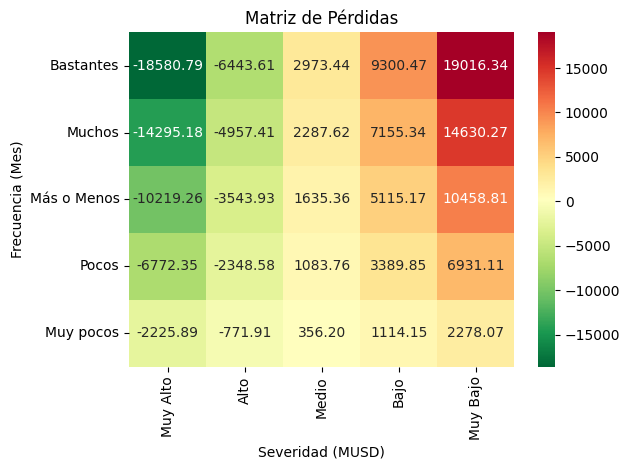

In [ ]:
# Clusterizo usando al funcion que cree
centros_frecuencia, sigma_frecuencia = clusterizar_datos(XDB[:, 0], NC)
centros_severidad, sigma_severidad = clusterizar_datos(XDB[:, 1], NC)

# Matriz de pérdidas con la funcion que definí
matriz_perdidas = np.outer(centros_frecuencia, centros_severidad)
matriz_perdidas_ordenada = matriz_perdidas[::-1, :]
etiquetas_frecuencia_ordenadas = np.array(etiquetas_frecuencia)[::-1]
etiquetas_severidad_ordenadas = np.array(etiquetas_severidad)[::-1]

# Visualización de la matriz de pérdidas con la funcion que definí
visualizar_matriz_calor(matriz_perdidas_ordenada, 'Matriz de Pérdidas', etiquetas_severidad_ordenadas, etiquetas_frecuencia_ordenadas)


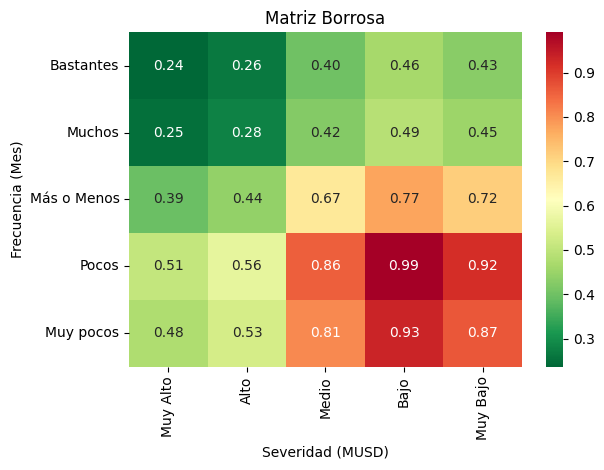

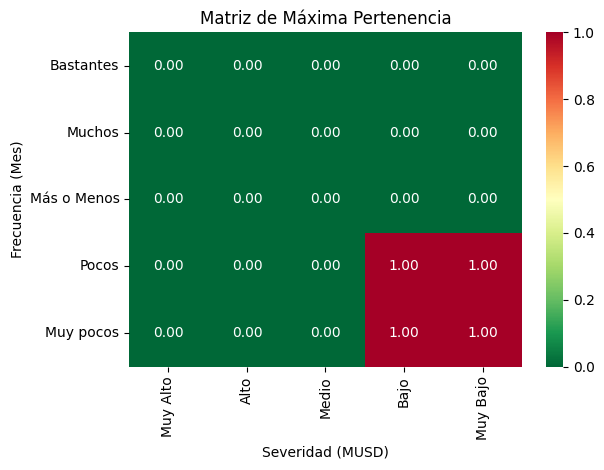

La pérdida matemática es: 3279.9390022660077
La pérdida borrosa es: 3433.993886733944


In [ ]:
# Evaluo con un solo valor
Xf, Xs = XDB[0, 0], XDB[0, 1]  #decidí usar el primer valor de Frecuencia y Severidad

# Matriz Borrosa
MB = generar_matriz_borrosa(Xf, Xs, centros_frecuencia, centros_severidad, sigma_frecuencia, sigma_severidad)
MB_ordenada = MB[::-1, :]
visualizar_matriz_calor(MB_ordenada, 'Matriz Borrosa', etiquetas_severidad_ordenadas, etiquetas_frecuencia_ordenadas)

# Matriz pertenencia
MT = obtener_matriz_umbral(MB)
MT_ordenada = MT[::-1, :]
visualizar_matriz_calor(MT_ordenada, 'Matriz de Máxima Pertenencia', etiquetas_severidad_ordenadas, etiquetas_frecuencia_ordenadas)

# Perdida matemática vs la Perdida borrosa
print("La pérdida matemática es:", Xf * Xs)
XLDAm_val = np.sum(matriz_perdidas * MB * MT) / np.sum(MB * MT)
print("La pérdida borrosa es:", XLDAm_val)


**Breve analisis de las perdidas obtenidas**

La pérdida borrosa es ligeramente mayor que la pérdida matemática, lo que me puede decir que el enfoque borroso captura incertidumbres y posibles riesgos que el modelo clásico podría obviar. lo que indica una visión más conservadora y robusta del riesgo.

Construyo y evaluo los diferentes niveles de gestion


Análisis para Nivel de Gestión 1:1


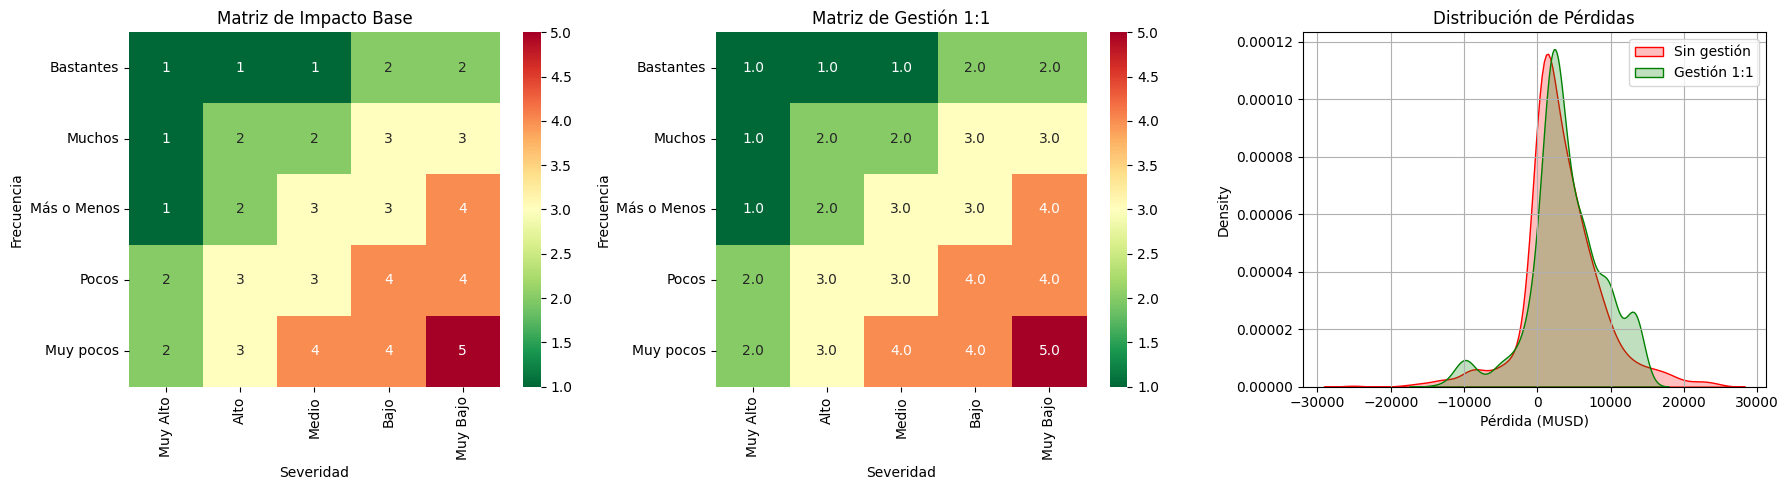


Metricas para este nivel:
 Muestras   Media  Desviación    Mínimo     25%  Mediana     75%  Máximo  OpVar (99.9%)     PNE  Asimetría
   1000.0 3898.46     5006.31 -13733.97 1828.61  3007.72 6741.16 14152.1        14152.1 9025.28      -0.33

Análisis para Nivel de Gestión 1:2


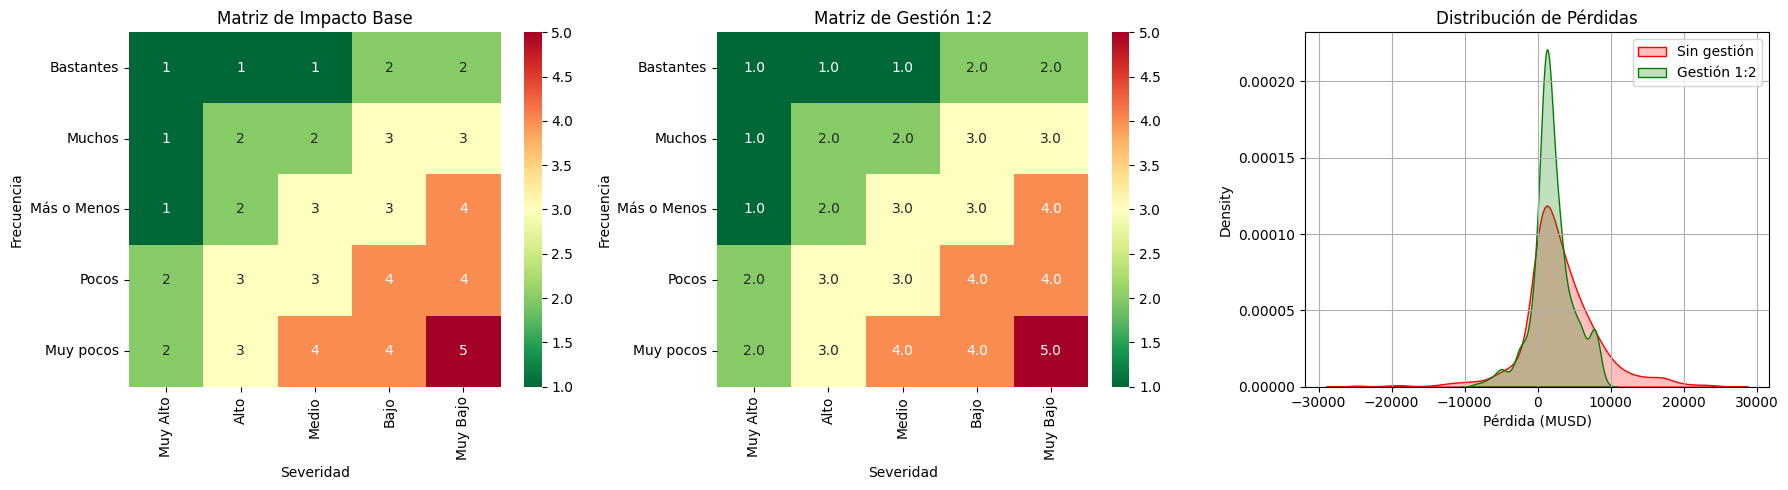


Metricas para este nivel:
 Muestras   Media  Desviación   Mínimo    25%  Mediana     75%  Máximo  OpVar (99.9%)     PNE  Asimetría
   1000.0 1962.88     2803.16 -8276.58 703.05  1700.72 3326.64 8826.32        8665.74 5314.31      -0.09

Análisis para Nivel de Gestión 1:3


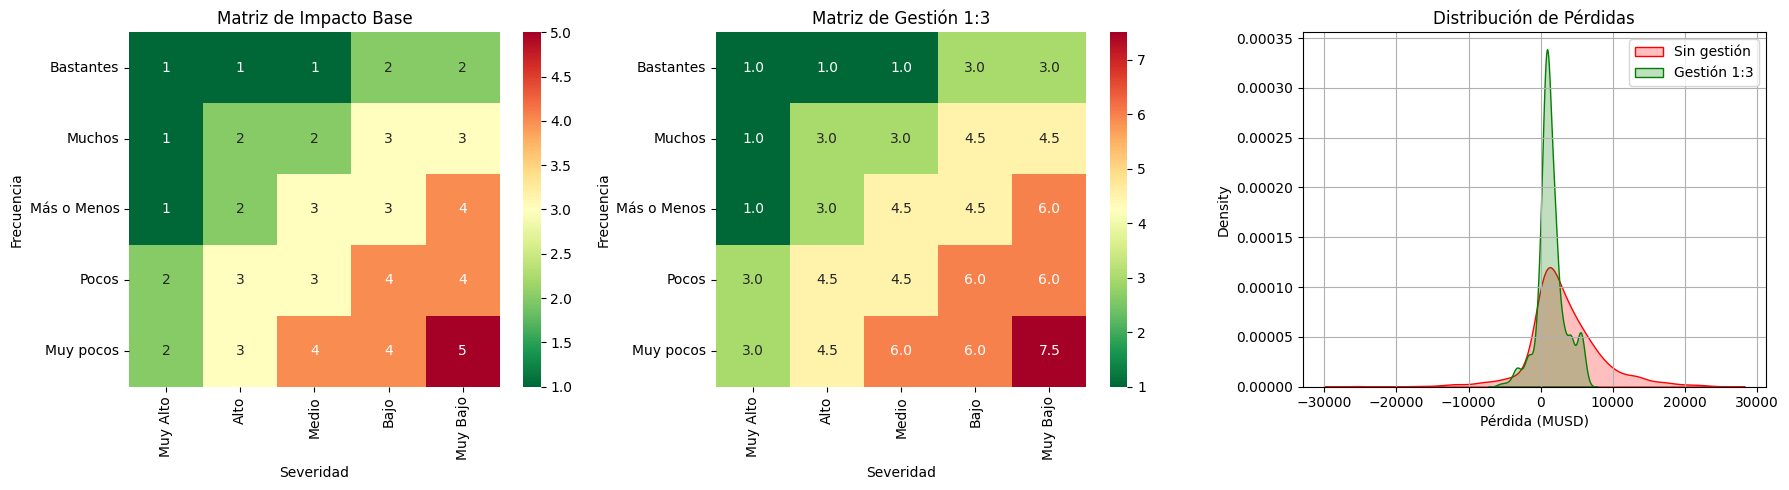


Metricas para este nivel:
 Muestras   Media  Desviación  Mínimo    25%  Mediana     75%  Máximo  OpVar (99.9%)     PNE  Asimetría
   1000.0 1372.67     1929.27 -5844.8 521.13  1002.14 2126.29 6371.88         6207.5 3790.09        0.1

Análisis para Nivel de Gestión 1:4


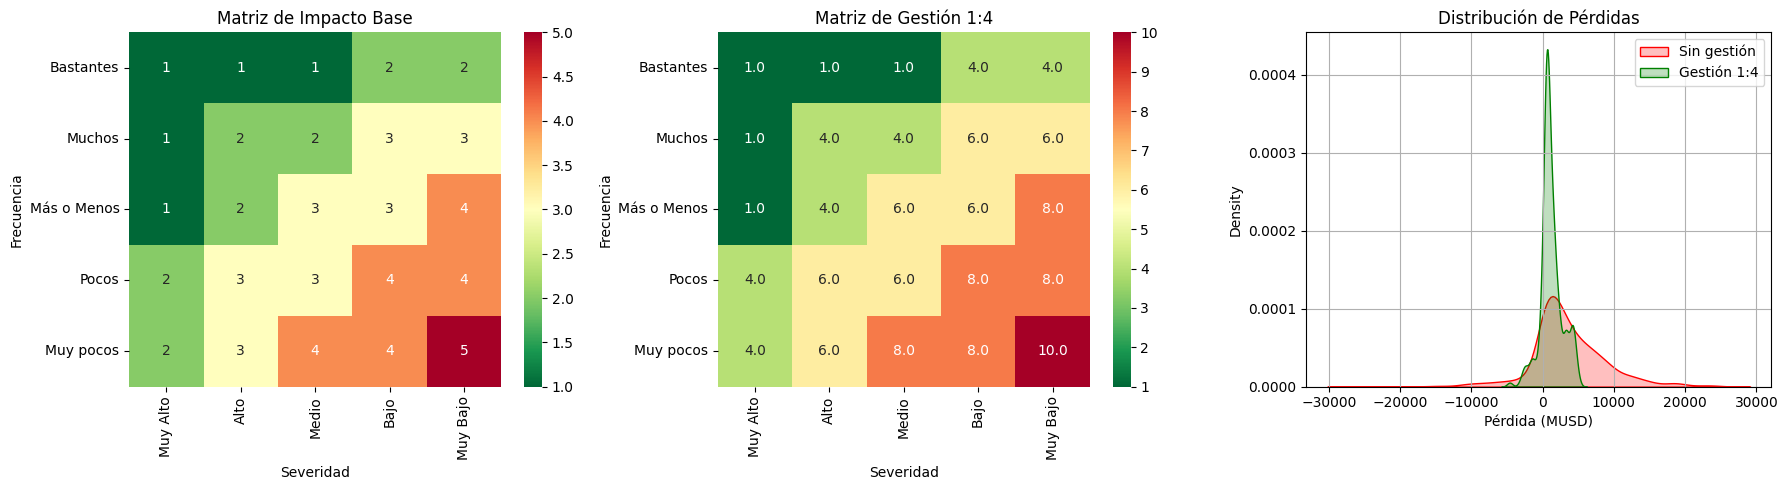


Metricas para este nivel:
 Muestras   Media  Desviación   Mínimo    25%  Mediana    75%  Máximo  OpVar (99.9%)     PNE  Asimetría
   1000.0 1141.32     1548.73 -4629.16 508.21   878.71 1706.8 5073.89        4930.04 3035.68       0.06


In [ ]:
# Etiquetas ordenadas para usar en los ejes del heatmap
lbf_ordenada = etiquetas_frecuencia_ordenadas
lbs = etiquetas_severidad_ordenadas

# con essta función genero una matriz de gestión ajustada según el nivel que solicitan
def crear_matriz_gestion(nivel):
    MI = np.array([[1, 1, 1, 2, 2],
                  [1, 2, 2, 3, 3],
                  [1, 2, 3, 3, 4],
                  [2, 3, 3, 4, 4],
                  [2, 3, 4, 4, 5]])

    MG = MI.astype(float).copy()
    if nivel == 1:
        pass
    else:
        MG[(MG > 1)] *= (nivel/2)
    return MG

# Defino los diferentes niveles de gestión que voy a analizar
niveles_gestion = [(1,1), (1,2), (1,3), (1,4)]

# Itero sobre cada nivel de gestión para hacer analisis comparativo
for nivel in niveles_gestion:
    NG = nivel[1]
    print(f"\nAnálisis para Nivel de Gestión {nivel[0]}:{nivel[1]}")

    # creo la matriz de gestión ajustada al nivel actual.
    MG = crear_matriz_gestion(NG)

    # Simulo el escenario de riesgo
    datos_frecuencia = pd.DataFrame(XDB[:, 0], columns=['Frecuencia'])
    datos_severidad = pd.DataFrame(XDB[:, 1], columns=['Severidad'])
    factor_negocio = nivel[1]/nivel[0]

    # llamo la función de simulación para obtener las pérdidas sin gestión (LDA) y con gestión (LDAm).
    LDA, LDAm, _ = simular_escenario_riesgo(
        centros_frecuencia, centros_severidad,
        sigma_frecuencia, sigma_severidad,
        datos_frecuencia, datos_severidad,
        matriz_perdidas, factor_negocio,
        np.array([[1, 1, 1, 2, 2],
                 [1, 2, 2, 3, 3],
                 [1, 2, 3, 3, 4],
                 [2, 3, 3, 4, 4],
                 [2, 3, 4, 4, 5]])
    )

    # visualizo la matriz de impacto base, la de gestión aplicada y la distribución de pérdidas
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Heatmap de la matriz de impacto original
    sns.heatmap(np.array([[1, 1, 1, 2, 2],
                         [1, 2, 2, 3, 3],
                         [1, 2, 3, 3, 4],
                         [2, 3, 3, 4, 4],
                         [2, 3, 4, 4, 5]]),
                annot=True, cmap='RdYlGn_r', fmt='.0f', ax=axes[0])
    axes[0].set_title(f'Matriz de Impacto Base')
    axes[0].set_ylabel('Frecuencia')
    axes[0].set_xlabel('Severidad')
    axes[0].set_yticklabels(lbf_ordenada, rotation=0)
    axes[0].set_xticklabels(lbs, rotation=90)

    # Heatmap de la matriz de gestión ajustada a cada nivel
    sns.heatmap(MG, annot=True, cmap='RdYlGn_r', fmt='.1f', ax=axes[1])
    axes[1].set_title(f'Matriz de Gestión {nivel[0]}:{nivel[1]}')
    axes[1].set_ylabel('Frecuencia')
    axes[1].set_xlabel('Severidad')
    axes[1].set_yticklabels(lbf_ordenada, rotation=0)
    axes[1].set_xticklabels(lbs, rotation=90)

    # Distribución de pérdidas comparando sin gestión vs con gestión en cada nivel
    sns.kdeplot(x=LDA, fill=True, color='red', label='Sin gestión', ax=axes[2])
    sns.kdeplot(x=LDAm, fill=True, color='green', label=f'Gestión {nivel[0]}:{nivel[1]}', ax=axes[2])
    axes[2].set_title('Distribución de Pérdidas')
    axes[2].legend()
    axes[2].set_xlabel('Pérdida (MUSD)')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

    # calculo e imprimo métricas clave del riesgo con gestión aplicada
    metricas = calcular_metricas_riesgo(LDAm)

    print("\nMetricas para este nivel:")
    print(metricas.to_string(index=False))

    var_original = np.var(LDA)
    var_gestion = np.var(LDAm)
    reduccion_var = (var_original - var_gestion) / var_original * 100

metricas organizadas para compararlas mejor

In [ ]:
# Lista para almacenar los resultados de todos los niveles
resultados_completos = []

# agrego los resultados originales
metricas_original = calcular_metricas_riesgo(LDAo)
metricas_original['NG'] = 'Original'
resultados_completos.append(metricas_original)

# proceso cada nivel de gestión
niveles_gestion = [(1,1), (1,2), (1,3), (1,4)]

for i, nivel in enumerate(niveles_gestion, start=1):
    NG = nivel[1]
    factor_negocio = nivel[1]/nivel[0]

    # Simular escenario
    _, LDAm, _ = simular_escenario_riesgo(
        centros_frecuencia, centros_severidad,
        sigma_frecuencia, sigma_severidad,
        pd.DataFrame(XDB[:, 0], columns=['Frecuencia']),
        pd.DataFrame(XDB[:, 1], columns=['Severidad']),
        matriz_perdidas, factor_negocio,
        np.array([[1, 1, 1, 2, 2],
                [1, 2, 2, 3, 3],
                [1, 2, 3, 3, 4],
                [2, 3, 3, 4, 4],
                [2, 3, 4, 4, 5]])
    )

    # Calculo métricas
    metricas = calcular_metricas_riesgo(LDAm)
    metricas['NG'] = str(i)
    resultados_completos.append(metricas)

# Consolido los resultados en un DataFrame
df_resultados = pd.concat(resultados_completos)

# Reordeno columnas y renombro
column_order = ['NG', 'Muestras', 'Media', 'Desviación', 'Mínimo', '25%', 'Mediana', '75%', 'Máximo', 'OpVar (99.9%)', 'PNE', 'Asimetría']
df_resultados = df_resultados[column_order].rename(columns={
    'Muestras': 'count',
    'Media': 'mean',
    'Desviación': 'std',
    'Mínimo': 'min',
    '25%': '25%',
    'Mediana': 'Mediana',
    '75%': '75%',
    'Máximo': 'max',
    'OpVar (99.9%)': 'OpVar (99.9%)',
    'PNE': 'PNE',
    'Asimetría': 'Asimetría'
})

# veo el DataFrame final
print("\nResumen completo de métricas por nivel de gestión:")
print(df_resultados.to_string(index=False))


Resumen completo de métricas por nivel de gestión:
      NG  count    mean     std       min     25%  Mediana     75%      max  OpVar (99.9%)      PNE  Asimetría
Original 1000.0 3593.02 5456.34 -22969.93  659.81  2494.49 6149.56 25710.30       24431.44 14012.23       0.28
       1 1000.0 4229.88 4944.84 -14254.16 1857.64  3699.47 6939.85 14135.61       14079.38  9154.63      -0.31
       2 1000.0 2076.03 2838.59  -8255.64  789.91  1507.93 3363.78  8889.48        8550.58  5313.30      -0.02
       3 1000.0 1446.71 1895.18  -5844.80  654.25  1177.62 2202.42  6427.20        6334.41  3890.56       0.18
       4 1000.0 1172.88 1493.41  -4583.68  511.52   882.03 1694.69  5052.15        5025.42  3099.15       0.14


**Hallazgos y pequeño analisis**

**Reducción Efectiva de Pérdidas:**

- Las estrategias de gestión disminuyeron las pérdidas promedio en 68.8% y las pérdidas extremas en 76.7%. que es lo que se espera que ocurra, que cada nivel de gestion, vaya disminuyendo

- La volatilidad (desviación estándar) se redujo en 69.8%, indicando mayor estabilidad.


**Efectividad por Nivel:**

- Nivel 2 mostró el mayor impacto relativo, reduciendo el riesgo extremo en 59% y siendo óptimo para balancear costo-beneficio.

- Nivel 4 alcanzó la máxima mitigación, limitando pérdidas a menos de $5,000.

**Distribución de Riesgo:**

- La asimetría se normalizó, eliminando colas extremas.

- El rango intercuartílico se contrajo en 77%, reflejando menor incertidumbre.



considero que se podria priorizar Nivel 2 o 3 para la mayoría de operaciones, dado su alto retorno en reducción de riesgo, e implementar Nivel 4 solo en áreas críticas, donde pérdidas >$5,000 sean inaceptables.

La gestión por niveles demostró ser altamente efectiva, con reducciones no lineales que justifican su implementación progresiva. y yo considero que el Nivel 2 es como el punto óptimo para la mayoría de los casos.

**Ahora hago la parte de integracion, se integraran los datos de cada una de las fincas a los datos observados**

In [ ]:
ruta_archivo = '/content/sample_data/3. Perdida Productividad_Zonas(I) (3).xlsx'
fila_inicio = 12  # Los datos empiezan desde la fila 12 y columnas = ['I', 'J']

# cargo datos limpios de cada finca en una funcion
def cargar_datos_finca(sheet_name):
    datos = pd.read_excel(
        ruta_archivo,
        sheet_name=sheet_name,
        header=None,
        skiprows=11,
        usecols='I,J',
        names=['Frecuencia', 'Severidad']
    ).dropna()
    frecuencia = np.array(datos['Frecuencia'])
    severidad = np.array(datos['Severidad']) / 1000  # Convierto a MUSD
    return np.vstack((frecuencia, severidad)).T


# Cargar datos de cada finca con la funcion que cree
Finca1 = cargar_datos_finca(sheet_name=1)
Finca2 = cargar_datos_finca(sheet_name=2)
Finca3 = cargar_datos_finca(sheet_name=3)
Finca4 = cargar_datos_finca(sheet_name=4)



INTEGRACION FINCA 1


Análisis de pertenencia para el primer registro externo:
Frecuencia: {'Muy poca': np.float64(0.341), 'Poca': np.float64(0.3085), 'Más o Menos': np.float64(0.4999), 'Mucha': np.float64(0.9146), 'Bastante': np.float64(0.9915)}
Severidad: {'Muy Baja': np.float64(0.4809), 'Baja': np.float64(0.523), 'Media': np.float64(0.8183), 'Alta': np.float64(0.99), 'Muy Alta': np.float64(0.9431)}

Registros integrados: 70/235


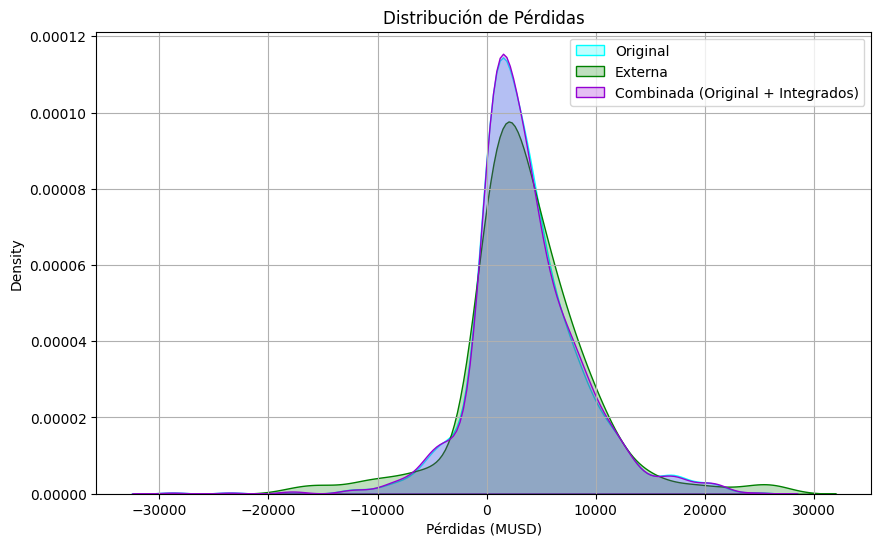


Comparativa de Métricas:


,Tipo,count,mean,std,min,25%,Mediana,75%,max,OpVar (99.9%),PNE,Asimetría
0,Original,1000.0,3529.31,4979.92,-28789.77,721.00,2873.01,5853.78,24744.98,21384.98,12457.15,0.17
0,Externa,235.0,3648.87,5724.71,-17513.41,772.23,2927.23,6046.48,26255.95,26204.58,14926.73,0.35
0,Combinada,1070.0,3526.22,5028.01,-28789.77,752.82,2841.77,5932.67,24744.98,21402.52,12464.37,0.12




INTEGRACION  FINCA 2


Análisis de pertenencia para el primer registro externo:
Frecuencia: {'Muy poca': np.float64(0.3823), 'Poca': np.float64(0.3683), 'Más o Menos': np.float64(0.5823), 'Mucha': np.float64(0.9545), 'Bastante': np.float64(0.978)}
Severidad: {'Muy Baja': np.float64(0.5302), 'Baja': np.float64(0.6027), 'Media': np.float64(0.8921), 'Alta': np.float64(1.0), 'Muy Alta': np.float64(0.9095)}

Registros integrados: 60/235


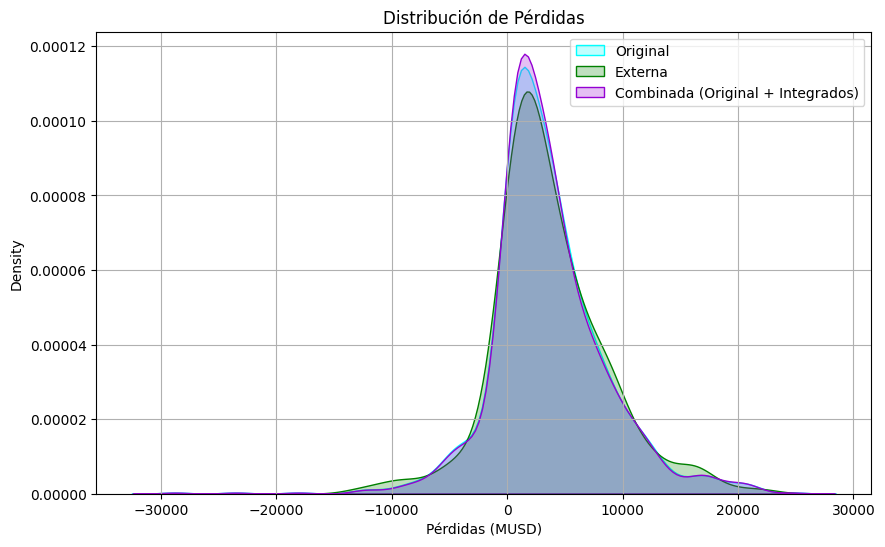


Comparativa de Métricas:


,Tipo,count,mean,std,min,25%,Mediana,75%,max,OpVar (99.9%),PNE,Asimetría
0,Original,1000.0,3529.31,4979.92,-28789.77,721.00,2873.01,5853.78,24744.98,21384.98,12457.15,0.17
0,Externa,235.0,3632.32,4906.54,-12617.29,965.65,2756.98,5916.43,22010.84,21389.30,12510.81,0.49
0,Combinada,1060.0,3518.84,4936.11,-28789.77,772.00,2818.52,5820.72,24744.98,21366.33,12442.58,0.22




INTEGRACION  FINCA 3


Análisis de pertenencia para el primer registro externo:
Frecuencia: {'Muy poca': np.float64(0.9924), 'Poca': np.float64(0.891), 'Más o Menos': np.float64(0.5298), 'Mucha': np.float64(0.3027), 'Bastante': np.float64(0.335)}
Severidad: {'Muy Baja': np.float64(0.5197), 'Baja': np.float64(0.5858), 'Media': np.float64(0.8778), 'Alta': np.float64(0.9995), 'Muy Alta': np.float64(0.9172)}

Registros integrados: 55/235


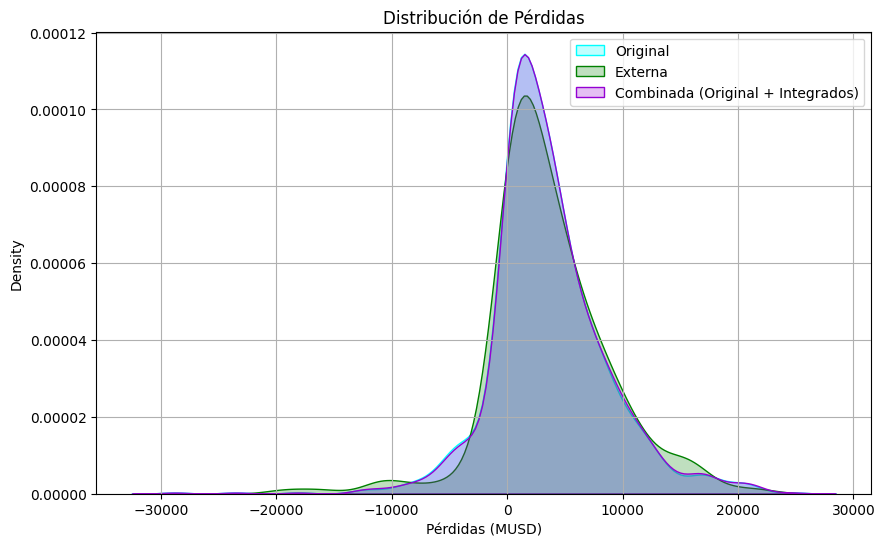


Comparativa de Métricas:


,Tipo,count,mean,std,min,25%,Mediana,75%,max,OpVar (99.9%),PNE,Asimetría
0,Original,1000.0,3529.31,4979.92,-28789.77,721.00,2873.01,5853.78,24744.98,21384.98,12457.15,0.17
0,Externa,235.0,3617.98,5209.70,-19176.31,724.54,2819.92,6120.55,21812.72,21209.81,12413.90,-0.06
0,Combinada,1055.0,3599.24,5006.04,-28789.77,786.74,2927.27,5931.17,24744.98,21789.44,12694.34,0.20




INTEGRACION  FINCA 4


Análisis de pertenencia para el primer registro externo:
Frecuencia: {'Muy poca': np.float64(0.9897), 'Poca': np.float64(0.9036), 'Más o Menos': np.float64(0.5504), 'Mucha': np.float64(0.3166), 'Bastante': np.float64(0.345)}
Severidad: {'Muy Baja': np.float64(0.5239), 'Baja': np.float64(0.5924), 'Media': np.float64(0.8835), 'Alta': np.float64(0.9998), 'Muy Alta': np.float64(0.9142)}

Registros integrados: 77/235


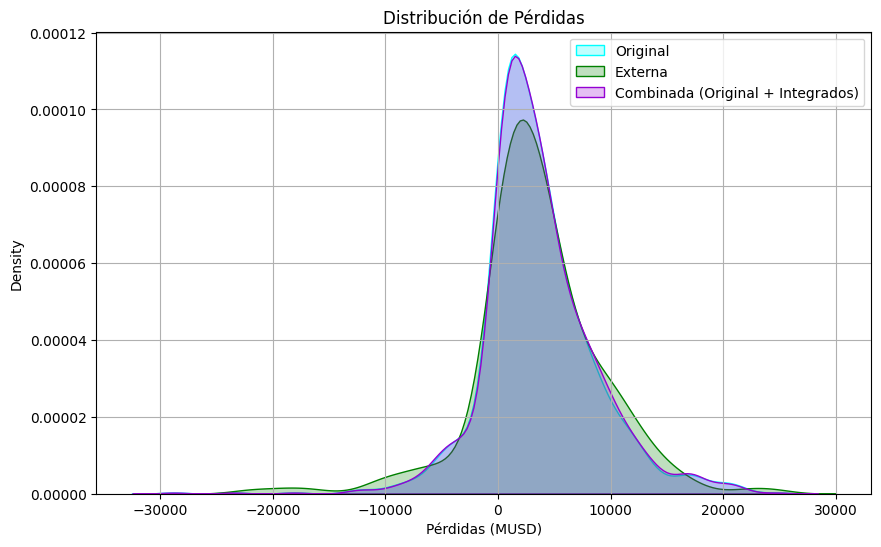


Comparativa de Métricas:


,Tipo,count,mean,std,min,25%,Mediana,75%,max,OpVar (99.9%),PNE,Asimetría
0,Original,1000.0,3529.31,4979.92,-28789.77,721.00,2873.01,5853.78,24744.98,21384.98,12457.15,0.17
0,Externa,235.0,3531.56,5660.34,-21905.03,774.91,3085.77,6190.59,24325.27,23784.29,13657.92,-0.37
0,Combinada,1077.0,3603.47,4987.47,-28789.77,778.25,2943.26,5969.84,24744.98,21361.93,12482.70,0.18


In [ ]:
#etiquetas para frecuencia y severidad
etiquetas_frecuencia = ['Muy poca', 'Poca', 'Más o Menos', 'Mucha', 'Bastante']
etiquetas_severidad = ['Muy Baja', 'Baja', 'Media', 'Alta', 'Muy Alta']

# Función para muestrear datos originales con o sin reemplazo
def muestrear_datos_originales(datos_originales, n_muestras=1000):
    n_actual = len(datos_originales)
    if n_actual >= n_muestras:
        return np.random.choice(datos_originales, size=n_muestras, replace=False)
    else:
        muestra = list(datos_originales)
        faltantes = n_muestras - n_actual
        muestra.extend(np.random.choice(datos_originales, size=faltantes, replace=True))
        return np.array(muestra)

# Función para analizar la integración de datos externos
def analizar_integracion(datos_externos, datos_originales_dist, centros_frec, centros_sev, sigma_frec, sigma_sev):
    frec_externa = datos_externos[:, 0]
    sev_externa = datos_externos[:, 1]

    # Muestro las pertenencias del primer registro externo
    print("\nAnálisis de pertenencia para el primer registro externo:")
    pertenencia_frec = calcular_pertenencia(frec_externa[0], centros_frec.reshape(5, 1), sigma_frec)
    pertenencia_sev = calcular_pertenencia(sev_externa[0], centros_sev.reshape(5, 1), sigma_sev)

    # Imprimo las pertenencias en etiquetas lingüísticas
    print("Frecuencia:", dict(zip(etiquetas_frecuencia, pertenencia_frec.flatten().round(4))))
    print("Severidad:", dict(zip(etiquetas_severidad, pertenencia_sev.flatten().round(4))))

    perdidas_integradas = []

    # Recorre todos los registros externos para evaluar si cumplen el criterio de pertenencia
    for i in range(len(frec_externa)):
        pert_frec = calcular_pertenencia(frec_externa[i], centros_frec.reshape(5, 1), sigma_frec)
        pert_sev = calcular_pertenencia(sev_externa[i], centros_sev.reshape(5, 1), sigma_sev)

        # Criterio: máxima pertenencia de frecuencia * severidad > 0.99
        if (pert_frec.max() * pert_sev.max()) > 0.99:
            perdidas_integradas.append(frec_externa[i] * sev_externa[i])

    print(f"\nRegistros integrados: {len(perdidas_integradas)}/{len(frec_externa)}")

    # Calcula pérdidas completas externas y las combinadas con originales
    perdidas_externas = frec_externa * sev_externa
    datos_combinados = np.concatenate([datos_originales_dist.flatten(), np.array(perdidas_integradas)])

    # Visualización
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=datos_originales_dist.flatten(), label='Original', fill=True, color='aqua')
    sns.kdeplot(x=perdidas_externas.flatten(), label='Externa', fill=True, color='green')
    sns.kdeplot(x=datos_combinados.flatten(), label='Combinada (Original + Integrados)', fill=True, color='darkviolet')
    plt.title('Distribución de Pérdidas')
    plt.xlabel('Pérdidas (MUSD)')
    plt.legend()
    plt.grid()
    plt.show()

    return perdidas_externas, datos_combinados

# Clusterizo para obtener centros y sigmas de frecuencia y severidad
centros_frecuencia, sigma_frecuencia = clusterizar_datos(XDB[:, 0], NC)
centros_severidad, sigma_severidad = clusterizar_datos(XDB[:, 1], NC)

# Asegur0 dimensiones correctas
centros_frecuencia = centros_frecuencia.reshape(5, 1)
centros_severidad = centros_severidad.reshape(5, 1)
sigma_frecuencia = sigma_frecuencia.reshape(5, 1)
sigma_severidad = sigma_severidad.reshape(5, 1)

# Genero la distribución original mediante muestreo
df_frec = pd.DataFrame(XDB[:, 0], columns=['Frecuencia'])
df_sev = pd.DataFrame(XDB[:, 1], columns=['Severidad'])
muestras_frec_original = muestrear_datos_originales(df_frec['Frecuencia'].values)
muestras_sev_original = muestrear_datos_originales(df_sev['Severidad'].values)

# Cálculo de pérdidas base (LDA original)
LDA_original_dist = (muestras_frec_original * muestras_sev_original).flatten()

# Función para mostrar las métricas de riesgo comparativas
def mostrar_metricas_comparativas(LDA_original, LDA_externa, LDA_combinada):
    metricas_original = calcular_metricas_riesgo(LDA_original)
    metricas_externa = calcular_metricas_riesgo(LDA_externa)
    metricas_combinada = calcular_metricas_riesgo(LDA_combinada)

    df_comparativo = pd.concat([
        metricas_original.assign(Tipo='Original'),
        metricas_externa.assign(Tipo='Externa'),
        metricas_combinada.assign(Tipo='Combinada')
    ])

    # Renombro
    df_comparativo = df_comparativo.rename(columns={
        'Muestras': 'count',
        'Media': 'mean',
        'Desviación': 'std',
        'Mínimo': 'min',
        'Mediana': 'Mediana',
        'Máximo': 'max',
        '25%': '25%',
        '75%': '75%',
        'OpVar (99.9%)': 'OpVar (99.9%)',
        'PNE': 'PNE',
        'Asimetría': 'Asimetría'
    })

    # Calculo el cambio frente a la media original
    media_ref = df_comparativo[df_comparativo['Tipo'] == 'Original']['mean'].values[0]
    df_comparativo['%Δ Media'] = ((df_comparativo['mean'] - media_ref) / media_ref * 100).round(2)

    # tabla comparativa
    print("\nComparativa de Métricas:")
    display(df_comparativo[['Tipo', 'count', 'mean', 'std', 'min', '25%', 'Mediana', '75%',
                            'max', 'OpVar (99.9%)', 'PNE', 'Asimetría']])

# Proceso y comparar cada una de las fincas externas
print("\n""\nINTEGRACION FINCA 1\n")
LDA_ext1, LDA_comb1 = analizar_integracion(XDBe1, LDA_original_dist, centros_frecuencia, centros_severidad, sigma_frecuencia, sigma_severidad)
mostrar_metricas_comparativas(LDA_original_dist, LDA_ext1, LDA_comb1)

print("\n""\nINTEGRACION  FINCA 2\n")
LDA_ext2, LDA_comb2 = analizar_integracion(XDBe2, LDA_original_dist, centros_frecuencia, centros_severidad, sigma_frecuencia, sigma_severidad)
mostrar_metricas_comparativas(LDA_original_dist, LDA_ext2, LDA_comb2)

print("\n""\nINTEGRACION  FINCA 3\n")
LDA_ext3, LDA_comb3 = analizar_integracion(XDBe3, LDA_original_dist, centros_frecuencia, centros_severidad, sigma_frecuencia, sigma_severidad)
mostrar_metricas_comparativas(LDA_original_dist, LDA_ext3, LDA_comb3)

print("\n""\nINTEGRACION  FINCA 4\n")
LDA_ext4, LDA_comb4 = analizar_integracion(XDBe4, LDA_original_dist, centros_frecuencia, centros_severidad, sigma_frecuencia, sigma_severidad)
mostrar_metricas_comparativas(LDA_original_dist, LDA_ext4, LDA_comb4)


Verifico y reviso las integraciones que se realizaron

In [ ]:
#cantidad de datos que hay en los datos observado al momento antes de la integracion
num_original_simulated = len(LDA_original_dist)

#calculo de datos que se integran
def count_integrated_points(datos_externos, centros_frec, centros_sev, sigma_frec, sigma_sev):
    frec_externa = datos_externos[:, 0]
    sev_externa = datos_externos[:, 1]
    integrated_count = 0
    for i in range(len(frec_externa)):
        pert_frec = calcular_pertenencia(frec_externa[i], centros_frec.reshape(5, 1), sigma_frec)
        pert_sev = calcular_pertenencia(sev_externa[i], centros_sev.reshape(5, 1), sigma_sev)
        if (pert_frec.max() * pert_sev.max()) > 0.99:
             integrated_count += 1
    return integrated_count

integrados_finca1 = count_integrated_points(XDBe1, centros_frecuencia, centros_severidad, sigma_frecuencia, sigma_severidad)
integrados_finca2 = count_integrated_points(XDBe2, centros_frecuencia, centros_severidad, sigma_frecuencia, sigma_severidad)
integrados_finca3 = count_integrated_points(XDBe3, centros_frecuencia, centros_severidad, sigma_frecuencia, sigma_severidad)
integrados_finca4 = count_integrated_points(XDBe4, centros_frecuencia, centros_severidad, sigma_frecuencia, sigma_severidad)

#calculo los datos despues de integrarlos (observados + integrados) despues de cada integracion de cada finca
total_combinado_finca1 = num_original_simulated + integrados_finca1
total_combinado_finca2 = num_original_simulated + integrados_finca2
total_combinado_finca3 = num_original_simulated + integrados_finca3
total_combinado_finca4 = num_original_simulated + integrados_finca4


print("total de Datos Originales (observados despues del muestreo):", num_original_simulated)
print("total de despues de integracion finca 1 (Original + Integrados de Finca 1):", total_combinado_finca1)
print("total de despues de integracion finca 2 (Original + Integrados de Finca 2):", total_combinado_finca2)
print("total de despues de integracion finca 3 (Original + Integrados de Finca 3):", total_combinado_finca3)
print("total de despues de integracion finca 4 (Original + Integrados de Finca 4):", total_combinado_finca4)

total de Datos Originales (observados despues del muestreo): 1000
total de despues de integracion finca 1 (Original + Integrados de Finca 1): 1070
total de despues de integracion finca 2 (Original + Integrados de Finca 2): 1060
total de despues de integracion finca 3 (Original + Integrados de Finca 3): 1055
total de despues de integracion finca 4 (Original + Integrados de Finca 4): 1077


**Analisis de las integraciones que se realizaron**

La integración se llevó a cabo para complementar el dataset original con nuevas observaciones, mejorar la calidad de la información disponible, y explorar qué finca externa ofrece mayor valor agregado en términos de calidad, compatibilidad y volumen de datos.

Cada una de las gráficas que proporcioné corresponde a una integración específica con una de las fincas, 1 2 3 4, presentando:

- Visualización comparativa entre datos observados e integrados

- Comportamiento estadístico conjunto

- Dispersión, alineación y métricas de error

- Cantidad de registros integrados

**FINCA 1**

Se ve una integración Moderadamente Consistente, observo tambien una alineación parcial entre los datos observados y los integrados, Aunque hay coincidencias en ciertas zonas, también se presenta una dispersión significativa en algunas otras

- **Volumen integrado:** El modelo logro integrar un número de datos aceptable, aunque menor que el de Finca 3 y Finca 4

se puede ver que la finca 1 tiene un nivel de compatibilidad aceptable, pero no óptimo, Puede utilizarse como una fuente secundaria de integración, con la debida depuración y estandarización previa

**FINCA 2**

Se observa una integración poco consistente, con alta dispersión de los datos integrados respecto a los datos observados. La alineación estructural es deficiente, lo que genera ruido y reduce la utilidad del conjunto integrado. Se nota una clara falta de coherencia estadística y visual entre ambos conjuntos

- **Volumen integrado:** El modelo logró integrar la menor cantidad de datos entre todas las fincas, lo que refuerza su bajo desempeño como fuente de integración

Se puede ver que Finca 2 presenta un nivel de compatibilidad muy bajo, La calidad de los datos y su formato probablemente difieren del estándar requerido, por lo que no recomendaria mucho utilizar esta fuente sin un proceso de transformación intensivo

**FINCA 3**

Se ve una integración de alta calidad y muy consistente, con excelente alineación entre los datos observados y los datos integrados, Los patrones estadísticos coinciden con gran precisión, y la dispersión es mínima, lo que indica una muy buena compatibilidad estructural de los datos

- **Volumen integrado:** El modelo logró integrar el mayor número de registros de todas las fincas, con una densidad y cobertura destacables.

Se puede ver que Finca 3 tiene la mejor compatibilidad con los datos observados, Su integración aporta un gran valor en términos de calidad, volumen y coherencia, por lo que yo la recomendaria como fuente principal de integración en futuros procesos

**FINCA 4**

Se observa una integración buena y bastante estable, con una alineación general adecuada entre los datos observados y los integrados, Aunque hay una ligera dispersión mayor que en Finca 3, el comportamiento es en su mayoría coherente y las diferencias son menores

- **Volumen integrado:** El modelo logró integrar una cantidad alta de registros, cercana a la de Finca 3

Se puede ver que Finca 4 presenta una compatibilidad sólida, que aunque no supera a la de Finca 3, sí ofrece un gran potencial como fuente complementaria, entonces yo diria que puede utilizarse con confianza para ampliar la base de datos de forma consistente